In [1]:
import sys
from os import path

if __package__ is None:
    #print("__package__ is None") 
    print(path.dirname( path.dirname( path.abspath('__file__') ) ))
    sys.path.append(path.dirname( path.dirname( path.abspath("__file__") ) ))
from Jutils import display_video

import mujoco_py
import copy
import os
import itertools
from IPython.display import clear_output, display, Image, HTML
import numpy as np
# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import PIL.Image

/home/yspark/Examples_Mujoco


# Example codes for Camera Setting in Gym Robotics 

In [135]:
# Setting camera distance, angles
'''
struct _mjvCamera                   // abstract camera
{
    // type and ids
    int      type;                  // camera type (mjtCamera)
    int      fixedcamid;            // fixed camera id
    int      trackbodyid;           // body id to track

    // abstract camera pose specification
    mjtNum   lookat[3];             // lookat point
    mjtNum   distance;              // distance to lookat point or tracked body
    mjtNum   azimuth;               // camera azimuth (deg)
    mjtNum   elevation;             // camera elevation (deg)
};
typedef struct _mjvCamera mjvCamera;

pos는 없는 듯함 (mjvGLCamera에는 있는데 에러보니까 gym에서 env.viewer.cam은 mjvCamera로 되던디...

if mode == "human":
    self.viewer = mujoco_py.MjViewer(self.sim)
elif mode == "rgb_array" or mode == "depth_array":
    self.viewer = mujoco_py.MjRenderContextOffscreen(self.sim, -1))

'''
def set_cam(env, config) :
    env.viewer.cam.distance = config['distance']
    env.viewer.cam.azimuth = config['azimuth'] # angle for horizontal
    env.viewer.cam.elevation = config['elevation'] # angle for vertical

    #env.viewer.move_camera(pos[0],pos[1],pos[2]) # move_camera에 들어가는 (?,?,?) parameter가 각각 뭘 뜻하는지 모르겠음. 주의할점 : 0이나 음수 값 넣으면 무한루프돌음
    # move_camera(action, dx / height, dy / height) # mujoco_py.MjViewer (move_camera로 pos정하는거 아닌가?)

# Setting camera pos : env.move_camera


Createing Video..


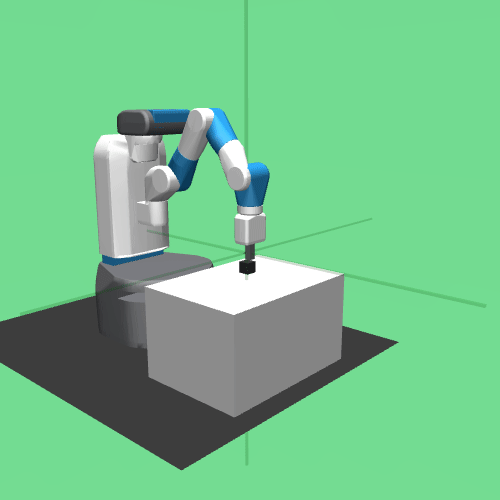

In [159]:
import gym
env_name = 'FetchPickAndPlace-v1'
env = gym.make(env_name) # Initalize with 'Humanoid-v3' - embedded in Gym
env.reset()

cam_config_1 = {'distance' : 2.5, 'azimuth' : 132.0, 'elevation' : -14.0}
cam_config_2 = {'distance' : 2.5, 'azimuth' : 64.0, 'elevation' : -14.0}
#env.viewer.move_camera()

video_1 = []
video_2 = []
'''
env.step()
Args:
    action (object): an action provided by the agent
Returns:
    observation (object): agent's observation of the current environment
    reward (float) : amount of reward returned after previous action
    done (bool): whether the episode has ended, in which case further step() calls will return undefined results
    info (dict): contains auxiliary diagnostic information (helpful for debugging, logging, and sometimes learning)
'''

for i in range(20):
    obs, reward, done, info = env.step(env.action_space.sample()) # take a random action
    pixels = env.render(mode='rgb_array')
    set_cam(env, cam_config_1)
    env.viewer.move_camera(1,-0.05*i, 0) # move_camera(action, dx / height, dy / height)
    video_1.append(env.render(mode='rgb_array').copy())
    #set_cam(env, cam_config_2)
    #video_2.append(env.render(mode='rgb_array').copy())

env.close()
print("Createing Video..")
display_video(video_1, gif=True)
#display_video(video_2, gif=True)


# Call to implementation : 

하나의 장면에 대해 여러 각도의 화면을 한 Video로 만드는 함수.

여러개의 화면을 수평 방향 일렬로 붙이거나, Grid 형태의 2X2 형태로 만들거나.



In [163]:
'''
env : env
cam_configs : configs for different angle
shape : (n,m) 모양 
'''

def render_multi_angle(env, cam_configs, shape) :
    if shape[0]*shape[1] != len(cam_configs):
        raise Exception('It cannot be expressed in entered array.')
    
    # 띄우기
    size = 300
    height_blank = np.array([[[255, 255, 255] for i in range(10)] for j in range(size)]) 
    width_blank = np.array([[[255, 255, 255] for i in range(size*shape[1] + 10*(shape[1]+1))] for j in range(10)])

    pixel = width_blank
    idx = 0

    for i in range(shape[0]): # 행
        pixel_temp = height_blank
        for j in range(shape[1]): # 열
            set_cam(env, cam_configs[idx])
            idx += 1
            pixel_temp = np.hstack([pixel_temp, env.render(mode='rgb_array', width=size, height=size).copy()]) # 옆으로 붙이기
            pixel_temp = np.hstack([pixel_temp, height_blank])
        pixel = np.vstack([pixel, pixel_temp]) # 위로 붙이기
        pixel = np.vstack([pixel, width_blank])

    return pixel

Createing Video..


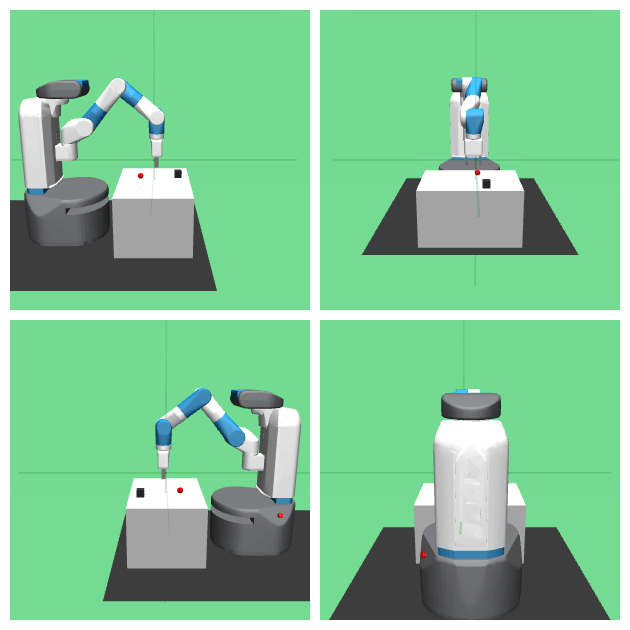

In [162]:
# Use Example
import gym
env_name = 'FetchPickAndPlace-v1'
env = gym.make(env_name)
env.reset()
env.render(mode='rgb_array')

cam_config_1 = {'distance' : 2.5, 'azimuth' : 90.0, 'elevation' : -14.0}
cam_config_2 = {'distance' : 2.5, 'azimuth' : 180.0, 'elevation' : -14.0} # 정면
cam_config_3 = {'distance' : 2.5, 'azimuth' : 270.0, 'elevation' : -14.0}
cam_config_4 = {'distance' : 2.5, 'azimuth' : 0.0, 'elevation' : -14.0}
cam_configs = [cam_config_1, cam_config_2, cam_config_3, cam_config_4]

video = [] 

print("Createing Video..")
for _ in range(10):
    obs, reward, done, info = env.step(env.action_space.sample()) # take a random action
    pixels = render_multi_angle(env, cam_configs,(2,2))
    video.append(pixels)

display_video(video, gif=True)

추가 요청사항 :
1. render 하는 화면의 Width, Height를 조정할 수 있는지. 가능하다면 이것도 별개의 세팅으로 다뤄야할듯

In [ ]:
# DEFAULT_SIZE = 500
# gym > envs > mujoco > mujoco_envs > render() 에서 변경 가능
# mujoco_envs.py render()

def render(
        self,
        mode="human",
        width=DEFAULT_SIZE,
        height=DEFAULT_SIZE,
        camera_id=None,
        camera_name=None,
    ):
        if mode == "rgb_array" or mode == "depth_array":
            if camera_id is not None and camera_name is not None:
                raise ValueError(
                    "Both `camera_id` and `camera_name` cannot be"
                    " specified at the same time."
                )

            no_camera_specified = camera_name is None and camera_id is None
            if no_camera_specified:
                camera_name = "track"

            if camera_id is None and camera_name in self.model._camera_name2id:
                camera_id = self.model.camera_name2id(camera_name)

            self._get_viewer(mode).render(width, height, camera_id=camera_id)

        if mode == "rgb_array":
            # window size used for old mujoco-py:
            data = self._get_viewer(mode).read_pixels(width, height, depth=False)
            # original image is upside-down, so flip it
            return data[::-1, :, :]
        elif mode == "depth_array":
            self._get_viewer(mode).render(width, height)
            # window size used for old mujoco-py:
            # Extract depth part of the read_pixels() tuple
            data = self._get_viewer(mode).read_pixels(width, height, depth=True)[1]
            # original image is upside-down, so flip it
            return data[::-1, :]
        elif mode == "human":
            self._get_viewer(mode).render()

## Unused codes

In [ ]:
def get_rand_action(n_action, lower_bounds = None, upper_bounds = None) :
    _ = np.random.uniform(low=lower_bounds, high=upper_bounds, size=n_action)
    return _


import gym
env = gym.make('Humanoid-v3') # Initalize with 'Humanoid-v3' - embedded in Gym
env.reset()
num_action = np.array(env.action_space.shape).sum()
#get_rand_action(bounds=num_action)
_ = get_rand_action(num_action, lower_bounds=np.zeros(num_action), upper_bounds = np.ones(num_action))
print(_)

[0.44643207 0.89642285 0.54069876 0.05261    0.53876308 0.58694733
 0.57269913 0.19629916 0.20814226 0.32408057 0.98974142 0.24232614
 0.34310946 0.59581271 0.13379268 0.72506118 0.0668755 ]


In [ ]:
!jupyter nbextension enable --py widgetsnbextension
from ipywidgets import *


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
